<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="5"><b><center>YANDEX MUSIC: FAISS BY TEAM 13</center></b></font>

# Содержание ноутбука

*В данном ноутбуке представлено поиск похожих композиций и ранжирование.*

# Задача

Нужно разработать ML-продукт, котороый:

    — Будет находить в датасете композиции похожие на мелодию А (формирующий некую группу)
    — Ранжирует все мелодии внутри группы по степени схожести (категориям): кавер, семпл, оригинал и т. д., 
    а так же датам создания (формирующий некую линейку эволюции композиции)



# Библиотеки

## Импорт библиотек

In [1]:
# импортируем библиотеки
import os
import re
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm, notebook

import tensorflow as tf
import tensorflow_hub as hub
try:
    import tensorflow_text as textb
except:
    # установим библиотеку tensorflow_text, если ранее не установили
    !pip install tensorflow_text
    import tensorflow_text as textb

import matplotlib.pyplot as plt
import seaborn as sns

try:
    import faiss
except:
    # установим библиотеку FAISS для работы на CPU, если ранее не установили
    !pip install faiss-cpu
    import faiss

from tqdm import tqdm, notebook
from scipy.sparse import csr_matrix, hstack
# from google.colab import drive

# зафиксируем параметр random state
RS = 45

2023-11-03 18:44:16.100705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Загрузка данных

In [2]:
# назначим папку загрузки
cwd = os.getcwd() + '/data_after/'
path_merge_data = cwd + 'merge_data.csv'

# разрешим Colab доступ к Google Drive, если работаем в Colab
try:
    drive.mount('/content/drive')
except:
    pass

In [3]:
# загрузим ранее сохраненный датасет с треками
try:
    merge_data = pd.read_csv(path_merge_data, index_col=0)
except:
    merge_data = pd.read_csv('/content/drive/MyDrive/covers_project/merge_data.csv', index_col=0)

# проверим результат
display(merge_data.head(6),
        merge_data.shape)

,text,track_id,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,genres_upd,is_normal_track,is_long_track,word_per_min,num_punct_text,mean_word_length,year_from_isrc,year_from_dttm,country_code
0,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd,1c4b1230f937e4c548ff732523214dcd,1.0,2018-09-26 02:24:21,сарафан,ru,aea0d1860569,foreignbard bard,2.333333,bard,1,0,7.116667,58,3.762431,2018,2018,ae
1,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8,none,0.0,2021-08-04 13:08:25,children,en,qzs672199805,electronics,3.576500,electronics,0,1,5.305142,12,4.034483,2021,2021,qz
2,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741,9c6dc41d5ccd9968d07f055da5d8f741,1.0,2010-05-20 05:00:14,briane,en,usum71006645,rock allrock,5.298500,allrock,0,0,29.494983,21,3.813291,2010,2010,us
3,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1,bfd04a73e9cffdf0e282c92219a86ea1,1.0,2014-09-23 12:07:56,briane,en,usm951100211,rock allrock,5.297667,allrock,0,0,29.490344,21,3.813291,2011,2014,us
4,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659,8d70930d09cd239c948408d1317d8659,1.0,2010-05-20 05:00:14,broken angel,en,usum71006638,rock allrock,5.354667,allrock,0,0,37.482667,43,4.060302,2010,2010,us
5,"You showed him all the best of you,\nBut I'm a...",b12ecdeac6ac42e1ecac96f9f15b1159,b12ecdeac6ac42e1ecac96f9f15b1159,1.0,2014-09-23 12:07:56,broken angel,en,usm951100203,rock allrock,5.353667,allrock,0,0,37.475667,43,4.060302,2011,2014,us


(9959, 19)

## Обработка текстов

In [4]:
# функция сохранения эмбеддингов
def save_emb(corpus, name):
    try:    # сохраним на Google Drive
        np.save('/content/drive/MyDrive/covers_project/'+f'{name}.npy', corpus)
    except: # либо сохраним локально
        np.save(cwd+f'{name}.npy', corpus)

# функция загрузки эмбеддингов
def load_emb(name):
    try:    # загрузим из Google Drive для Colab
        corpus = np.load('/content/drive/MyDrive/covers_project/'+f"{name}.npy")
    except: # либо загрузим локально
        corpus = np.load(cwd+f"{name}.npy")

    return corpus

# функция получения эмбеддингов
def get_emb(col:str):
    corpus = []
    use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
    for r in tqdm(data[col].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        corpus.append(review_emb)
    return corpus

# функция очистки текста от лишних символов
def clear_text(text):
    cleared_text = re.sub(r"[^\w\s\d]|_", " ", text)
    cleared_text =  re.sub(r'\n', " ", cleared_text)
    cleared_text = re.sub("[0-9]+", "", cleared_text)
    return cleared_text

In [5]:
# загрузим ранее сохраненные эмбеддинги текстов и названий треков
try:
    corpus_text = load_emb('corpus_text_no_balanced')
    corpus_title = load_emb('corpus_title_no_balanced')

# либо получим эмбеддинги
except:
    # очистим данные от лишних символов
    data = merge_data.copy()
    data['title'] = data['title'].apply(clear_text)
    data['text'] = data['text'].apply(clear_text)
    # проверим результат
    display(data['title'].head(3),
            data['text'].head(3))

    # преобразуем данные в эмбеддинги, сохраним результат
    corpus_title = get_emb('title')
    save_emb(corpus_title, 'corpus_title_no_balanced')
    corpus_text = get_emb('text')
    save_emb(corpus_text, 'corpus_text_no_balanced')

    # загрузим сохраненные эмбеддинги
    corpus_text = load_emb('corpus_text_no_balanced')
    corpus_title = load_emb('corpus_title_no_balanced')

# проверим результат
display(corpus_text.shape,
        corpus_text[:3],
        corpus_title.shape,
        corpus_title[:3],
        )

(9959, 512)

array([[-0.00273536,  0.03406541, -0.01655436, ..., -0.00177204,
         0.01739489,  0.03707733],
       [-0.00849978, -0.05532836,  0.02762957, ...,  0.02761288,
         0.0347824 , -0.03353512],
       [-0.07125755, -0.00818843,  0.01622328, ..., -0.0462678 ,
         0.0508328 ,  0.09505969]], dtype=float32)

(9959, 512)

array([[-0.0153765 , -0.01522934, -0.0129895 , ...,  0.00044379,
         0.05824359, -0.01413989],
       [-0.03464546,  0.05401406, -0.07325189, ...,  0.01435751,
         0.03078001, -0.08372374],
       [ 0.01225703, -0.05260774,  0.03612205, ..., -0.04440716,
         0.04076431,  0.0025151 ]], dtype=float32)

In [6]:
# объединим эмбеддинги текстов и названий треков
updated_text = np.concatenate([corpus_text, corpus_title], axis=1)

# проверим результат
display(updated_text.shape,
        updated_text[:5])

(9959, 1024)

array([[-0.00273536,  0.03406541, -0.01655436, ...,  0.00044379,
         0.05824359, -0.01413989],
       [-0.00849978, -0.05532836,  0.02762957, ...,  0.01435751,
         0.03078001, -0.08372374],
       [-0.07125755, -0.00818843,  0.01622328, ..., -0.04440716,
         0.04076431,  0.0025151 ],
       [-0.07125755, -0.00818843,  0.01622328, ..., -0.04440716,
         0.04076431,  0.0025151 ],
       [-0.02504153, -0.0196219 , -0.00630468, ..., -0.00472459,
        -0.05776468, -0.00820716]], dtype=float32)

## FAISS

Для поиска похожих композиций применим FAISS, разработку команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве. Высокая скорость поиска позволяет работать с очень большими данными – до нескольких миллиардов векторов.

Основное преимущество FAISS – state-of-the-art результаты на GPU, при этом его реализация на CPU незначительно проигрывает hnsw (nmslib), это дает возможность вести поиск как на CPU, так и на GPU. Кроме того, FAISS оптимизирован в части использования памяти и поиска на больших батчах.

Найдем кластеры для каждого трека с помощью FAISS:

In [7]:
# зададим векторы для FAISS
vectors = updated_text

In [8]:
dim = vectors.shape[1]  # размер вектора
nb = vectors.shape[0]   # количество векторов в наборе
nq = 1                  # количество векторов в выборке для поиска
query = vectors         # выборка векторов

In [9]:
# создадим Flat индекс и добавим векторы без обучения
index = faiss.IndexFlatL2(dim)
print(index.ntotal)  # пока индекс пустой
index.add(vectors)   # добавим векторы
print(index.ntotal)  # проверим результат

0
9959


In [10]:
# найдем ближайших соседей для векторов из выборки
topn = 10    # лимит количества ближайших соседей
D, I = index.search(query, topn)  # возвращает результат: Distances, Indices
print(I)
display(D)

[[   0  223 7292 ... 6161 5286 6500]
 [   1  492 5499 ... 9366 9594 8437]
 [   2    3 7710 ... 7701 3554 4294]
 ...
 [9956 8660 6615 ... 8930 1035 6191]
 [9957  412 4515 ... 5993 4946 4551]
 [9958 7256 2051 ... 9025 9252 5174]]


array([[4.7683716e-07, 1.3390064e+00, 1.5736322e+00, ..., 1.8097820e+00,
        1.8161194e+00, 1.8202500e+00],
       [0.0000000e+00, 1.6092772e+00, 1.6208715e+00, ..., 2.0682776e+00,
        2.0837114e+00, 2.1441772e+00],
       [4.7683716e-07, 4.7683716e-07, 1.3257856e+00, ..., 1.5990622e+00,
        1.6002047e+00, 1.6088367e+00],
       ...,
       [0.0000000e+00, 7.6479793e-01, 1.3396566e+00, ..., 1.5764670e+00,
        1.5770357e+00, 1.5829792e+00],
       [0.0000000e+00, 1.0609810e+00, 1.1018806e+00, ..., 1.4636128e+00,
        1.4790864e+00, 1.4952967e+00],
       [4.7683716e-07, 5.6597996e-01, 6.2361288e-01, ..., 8.8348699e-01,
        8.8810039e-01, 9.2435169e-01]], dtype=float32)

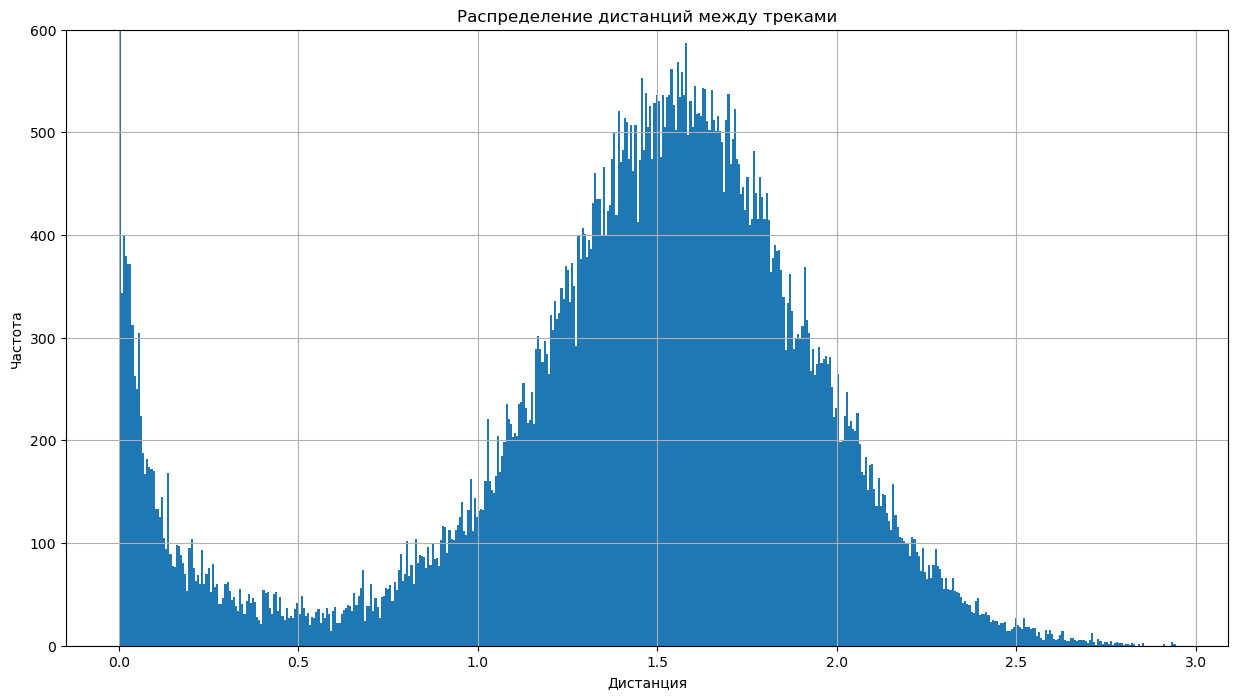

In [11]:
# проверим распределение дистанций между треками
plt.figure(figsize=(15, 8))
pd.Series(D.flatten().tolist()).hist(bins=500)
plt.title('Распределение дистанций между треками')
plt.xlabel('Дистанция')
plt.ylabel('Частота')
plt.ylim(0, 600)
plt.show()

In [12]:
# рассмотрим пример похожих текстов
display(merge_data.loc[I[7, 1], 'text'],
        "",
        merge_data.loc[7, 'text'])

'You lost her\nAnd now you\'re wishing you could take back\nWhat you did wrong\nYou lost him\nHow could he breathe with the pressure that you put on?\nHow come being proud always feels so wrong\nWhen you hurt the one you love?\nBut still you find a way to wonder why\n\nBehind those walls that won\'t come down\nI\'m sure you had more things to say\nYou\'re upside down and inside out\nCause I\'m sure you had more things to say\n\nWhen time passes by\nYou\'ll start to see how one word\nCould\'ve changed it all\nThere\'s so much more than "I"\nWhen five letters were enough\nTo prevent this fall\n\nHow come saying "sorry" comes so easily\nWhen you\'ve had some time to grieve\nBut still you find a way to wonder why\n\nBehind those walls that won\'t come down\nI\'m sure you had more things to say\nYou\'re upside down and inside out\nCause I know you\'ve had more things to say\nBut there\'s always someone else you blame\n\nOh just look where it\'s got you now\nYou tell yourself that it\'s okay

''

'You lost her\nAnd now you\'re wishing you could take back\nWhat you did wrong\nYou lost him\nHow could he breathe with the pressure that you put on?\nHow come being proud always feels so wrong\nWhen you hurt the one you love?\nBut still you find a way to wonder why\n\nBehind those walls that won\'t come down\nI\'m sure you had more things to say\nYou\'re upside down and inside out\nCause I\'m sure you had more things to say\n\nWhen time passes by\nYou\'ll start to see how one word\nCould\'ve changed it all\nThere\'s so much more than "I"\nWhen five letters were enough\nTo prevent this fall\n\nHow come saying "sorry" comes so easily\nWhen you\'ve had some time to grieve\nBut still you find a way to wonder why\n\nBehind those walls that won\'t come down\nI\'m sure you had more things to say\nYou\'re upside down and inside out\nCause I know you\'ve had more things to say\nBut there\'s always someone else you blame\n\nOh just look where it\'s got you now\nYou tell yourself that it\'s okay

Сходство треков очевидно.

In [13]:
def get_clusters(vectors, merge_data, topn=10, threshold=.5):

    """Функция принимает:
        - эмбеддинги
        - датасет с треками
        - лимит на размер кластера
        - порог срабатывания похожести
       Добавляет в датасет для каждого трека его кластер, содержащий
       индексы, расстояния между треками и id треков, входящих в кластер."""

    cluster_data = merge_data.reset_index(drop=True).copy()

    dim = vectors.shape[1]  # размер вектора
    nb = vectors.shape[0]   # количество векторов в наборе

    # создадим Flat индекс и добавим векторы без обучения
    index = faiss.IndexFlatL2(dim)
    index.add(vectors)

    # найдем расстояние между похожими треками и их индексы
    D, I = index.search(vectors, topn)

    # добавим id треков кластера
    cluster_data['cluster_distances'] = [[distance for distance in row[1:] if distance < threshold] for row in D]

    # отфильтруем индексы треков, проходящих порог схожести
    I_filtered = np.where(D < threshold, I, I * -1)

    # добавим индексы треков кластера
    cluster_data['cluster_indexes'] = [[index for index in row[1:] if index >= 0] for row in I_filtered]
    cluster_data['cluster_track_ids'] = [[cluster_data.loc[index, 'track_id'] for index in row[1:] if index >= 0] for row in I_filtered]

    return cluster_data

In [14]:
%%time
# найдем кластеры треков
cluster_data = get_clusters(vectors, merge_data, 30, .5)

# проверим результат
cluster_data.sample(10, random_state=RS)

CPU times: user 9.51 s, sys: 198 ms, total: 9.71 s
Wall time: 1.98 s


,text,track_id,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,...,is_long_track,word_per_min,num_punct_text,mean_word_length,year_from_isrc,year_from_dttm,country_code,cluster_distances,cluster_indexes,cluster_track_ids
9811,Cómo fue\nNo sé decirte cómo fue\nNo sé explic...,c0677c6bfffec323172bc027ad5a4f10,none,0.0,2022-01-25 14:46:07,como fue,es,arixb2200490,folk latinfolk,3.453167,...,1,7.021439,0,3.696721,2022,2022,ar,[],[],[]
3497,"We want, information, information, information...",7fb9be3813f4a61d6eeec8e42a947a97,none,0.0,2013-03-11 20:00:00,the prisoner,en,uspa30000359,classicmetal metal,6.313667,...,0,25.359894,41,3.671233,2000,2013,us,[],[],[]
3111,Been hidin' out and layin' low\nIt's nothing n...,e8ba200ab574100e59c9518625ef5b8a,none,0.0,2011-03-20 21:00:00,out ta get me,en,usat21100243,hardrock allrock,4.234000,...,0,22.087367,62,3.903915,2011,2011,us,[],[],[]
358,"Baby, I'm wasted\nAll I wanna do is drive home...",c3e7fb5aee91bc44f3d6ffb64baead9a,none,0.0,2021-07-27 21:00:00,faded,en,gbsmu9159904,dance,2.501167,...,0,7.836989,14,3.511364,1991,2021,gb,"[0.02456379, 0.025910378, 0.02854824, 0.030673...","[4642, 2002, 3900, 6098]","[0d828c1ff824e074a8d0c8aeedd75bc2, ee89ce67b72..."
4153,"Если не звонит, значит всё уже в прошлом\nОн т...",ce45408c27dbf83e51a606404cc54b94,ce45408c27dbf83e51a606404cc54b94,1.0,2021-11-23 21:00:00,забудь,ru,frx872161866,pop ruspop,2.447667,...,0,10.239406,43,4.092369,2021,2021,fr,[],[],[]
9317,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef,b9213d37c37deffe8b8af0dac5d0c3c4,0.0,2014-02-03 20:00:00,everlasting love,en,ussm10019543,pop,4.025000,...,0,22.472917,67,4.381538,2000,2014,us,"[2.3841858e-07, 2.3841858e-07, 0.09046006, 0.1...","[9317, 9318, 9538, 1490, 1491, 8464, 7960, 326...","[0021519c8533f1116591948bbb349aef, cd4b82e967d..."
9176,É de sonho e de pó\nO destino de um só\nFeito ...,561e63c612f11af8bdc6b6fd8b38cfe0,none,0.0,2019-11-17 21:00:00,romaria,pt,br4r21900006,folk,4.023500,...,0,15.088125,14,4.227679,2019,2019,br,[],[],[]
5951,Entrei na rua dela com meu carro rebaixado\nNo...,09ef9ad4bb5a4438d6132ea6cf2bf8c4,none,0.0,2021-02-13 05:29:11,tá rocheda,pt,us7vg2141758,folk latinfolk,3.460333,...,1,12.803233,22,4.445455,2021,2021,us,[],[],[]
6803,Senja datang sambut sang bulan\nIringi langkah...,b094fe7012a6370d684360d3b0b3b021,none,0.0,2020-12-16 21:00:00,salam untuk dia,id,dga052085520,punk,4.848167,...,0,9.857939,9,6.225000,2020,2020,dg,[],[],[]
7810,"I'm low, low, low, lost\nI swear I will be bet...",5613da174f44f6ccaa6a389fbc21cc61,5613da174f44f6ccaa6a389fbc21cc61,1.0,2022-09-01 21:00:00,lost,en,gb8ke2208785,dance,3.300000,...,1,14.850000,48,3.707692,2022,2022,gb,[],[],[]


Для каждого трека были найдены похожие композиции

In [15]:
cluster_data['cluster_distances'] = cluster_data['cluster_distances'].apply(lambda x: 'no_similar' if (len(x) == 0) else x)
cluster_data['cluster_indexes'] = cluster_data['cluster_indexes'].apply(lambda x: 'no_similar' if (len(x) == 0) else x)
cluster_data['cluster_track_ids'] = cluster_data['cluster_track_ids'].apply(lambda x: 'no_similar' if (len(x) == 0) else x)

In [16]:
cluster_data.sample(10, random_state=RS)

,text,track_id,original_track_id,track_remake_type,dttm,title,language,isrc,genres,duration,...,is_long_track,word_per_min,num_punct_text,mean_word_length,year_from_isrc,year_from_dttm,country_code,cluster_distances,cluster_indexes,cluster_track_ids
9811,Cómo fue\nNo sé decirte cómo fue\nNo sé explic...,c0677c6bfffec323172bc027ad5a4f10,none,0.0,2022-01-25 14:46:07,como fue,es,arixb2200490,folk latinfolk,3.453167,...,1,7.021439,0,3.696721,2022,2022,ar,no_similar,no_similar,no_similar
3497,"We want, information, information, information...",7fb9be3813f4a61d6eeec8e42a947a97,none,0.0,2013-03-11 20:00:00,the prisoner,en,uspa30000359,classicmetal metal,6.313667,...,0,25.359894,41,3.671233,2000,2013,us,no_similar,no_similar,no_similar
3111,Been hidin' out and layin' low\nIt's nothing n...,e8ba200ab574100e59c9518625ef5b8a,none,0.0,2011-03-20 21:00:00,out ta get me,en,usat21100243,hardrock allrock,4.234000,...,0,22.087367,62,3.903915,2011,2011,us,no_similar,no_similar,no_similar
358,"Baby, I'm wasted\nAll I wanna do is drive home...",c3e7fb5aee91bc44f3d6ffb64baead9a,none,0.0,2021-07-27 21:00:00,faded,en,gbsmu9159904,dance,2.501167,...,0,7.836989,14,3.511364,1991,2021,gb,"[0.02456379, 0.025910378, 0.02854824, 0.030673...","[4642, 2002, 3900, 6098]","[0d828c1ff824e074a8d0c8aeedd75bc2, ee89ce67b72..."
4153,"Если не звонит, значит всё уже в прошлом\nОн т...",ce45408c27dbf83e51a606404cc54b94,ce45408c27dbf83e51a606404cc54b94,1.0,2021-11-23 21:00:00,забудь,ru,frx872161866,pop ruspop,2.447667,...,0,10.239406,43,4.092369,2021,2021,fr,no_similar,no_similar,no_similar
9317,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef,b9213d37c37deffe8b8af0dac5d0c3c4,0.0,2014-02-03 20:00:00,everlasting love,en,ussm10019543,pop,4.025000,...,0,22.472917,67,4.381538,2000,2014,us,"[2.3841858e-07, 2.3841858e-07, 0.09046006, 0.1...","[9317, 9318, 9538, 1490, 1491, 8464, 7960, 326...","[0021519c8533f1116591948bbb349aef, cd4b82e967d..."
9176,É de sonho e de pó\nO destino de um só\nFeito ...,561e63c612f11af8bdc6b6fd8b38cfe0,none,0.0,2019-11-17 21:00:00,romaria,pt,br4r21900006,folk,4.023500,...,0,15.088125,14,4.227679,2019,2019,br,no_similar,no_similar,no_similar
5951,Entrei na rua dela com meu carro rebaixado\nNo...,09ef9ad4bb5a4438d6132ea6cf2bf8c4,none,0.0,2021-02-13 05:29:11,tá rocheda,pt,us7vg2141758,folk latinfolk,3.460333,...,1,12.803233,22,4.445455,2021,2021,us,no_similar,no_similar,no_similar
6803,Senja datang sambut sang bulan\nIringi langkah...,b094fe7012a6370d684360d3b0b3b021,none,0.0,2020-12-16 21:00:00,salam untuk dia,id,dga052085520,punk,4.848167,...,0,9.857939,9,6.225000,2020,2020,dg,no_similar,no_similar,no_similar
7810,"I'm low, low, low, lost\nI swear I will be bet...",5613da174f44f6ccaa6a389fbc21cc61,5613da174f44f6ccaa6a389fbc21cc61,1.0,2022-09-01 21:00:00,lost,en,gb8ke2208785,dance,3.300000,...,1,14.850000,48,3.707692,2022,2022,gb,no_similar,no_similar,no_similar


Найденные композиции исполнены в разном жанре, не только оригиналы, но есть и каверы, разного года регистрации, так же они могут быть на разных языках.

Напишем функцию, которая вовзращает для каждого трека отсортированный список с похожими треками.
Порядок похожих композиций будет следующим - сначала идут оригиналы, потом каверы. Все внутренние группы (оригиналы и каверы) будут отсортированы по году исполнения.

In [17]:
def get_group_for_track(track_id):
    res = 'no_similiar'
    df_for_track = cluster_data.query('track_id == @track_id')
    group_sim = df_for_track['cluster_track_ids']
    if group_sim.values[0] != 'no_similar':
        dct_type = dict(zip(cluster_data['track_id'], cluster_data['track_remake_type']))
        dct_year = dict(zip(cluster_data['track_id'], cluster_data['year_from_isrc']))
        lst_orig = [t for t in group_sim.values[0] if dct_type[t] == 1]
        lst_cover = [t for t in group_sim.values[0] if dct_type[t] == 0]
        lst_full = []
        for l in [lst_orig, lst_cover]:
            dct = dict(zip(l, (dct_year.get(key) for key in dct_year)))
            sorted_dict = {k: v for k, v in sorted(dct.items(), key=lambda item: item[1])}
            sort_lst = list(sorted_dict.keys())
            lst_full.extend(sort_lst)
        res = lst_full
    return res

In [18]:
get_group_for_track('0021519c8533f1116591948bbb349aef')

['522fd9c3fe5138702f643e79b49984a7',
 'b9213d37c37deffe8b8af0dac5d0c3c4',
 '58a293c4c86b4c0000b0e683c77432a8',
 'd1b9dda73d62a6e9d3c1a9d07b9d5b2d',
 'f9856ecd215642c46ec691fc95fe210f',
 '79eb48bb4409051aab1602e390c98736',
 '7c9052caed90949c46c171951cd9dc3d',
 'a106cea5c02ed8a70b421831cc4e7192',
 '9ec1fd0f1144a6faca03a8aae2616bc5',
 '0021519c8533f1116591948bbb349aef',
 'c4da5795e1e9d7ee001845e5cf07030b',
 'cd4b82e967d4a937f66ec5ef57bec168']

# Вывод по этапу поиска похожих композиций

        Был реализован поиск похожих композиций с помощью библиотеки FAISS. С помощью нее
        осуществляется поиск в векторном пространстве группы похожих треков, благодаря оптимизации  в части 
        использования памяти, поиск на больших батчах не будет заниматься много времени.
        
        Так же было добавлено ранжирование найденной группы по типу трека (оригина, а потом кавер), и внутреннее 
        ранжирование для каждой групп по году исполнения. Год исполнения (год регистрации) был взят из кода isrc.
        
        Такой подход позволит пользователю более точно настраивать свою ленту рекомендаций.